In [229]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import decomposition
from importlib import reload
reload(decomposition)
from decomposition import Picture_decomposition
decomp = Picture_decomposition('CyberextruderUltimate/', '000001.jpg', 50)

#from IPython.display import Image
#from IPython.core.display import HTML 


# 1. Коллаж лиц из датасета

Показываем первые 25 лиц с названием 000001.jpg.

In [59]:
decomp = Picture_decomposition_old('CyberextruderUltimate/', '000001.jpg', 50)

In [5]:
pics = decomp.get_pics()

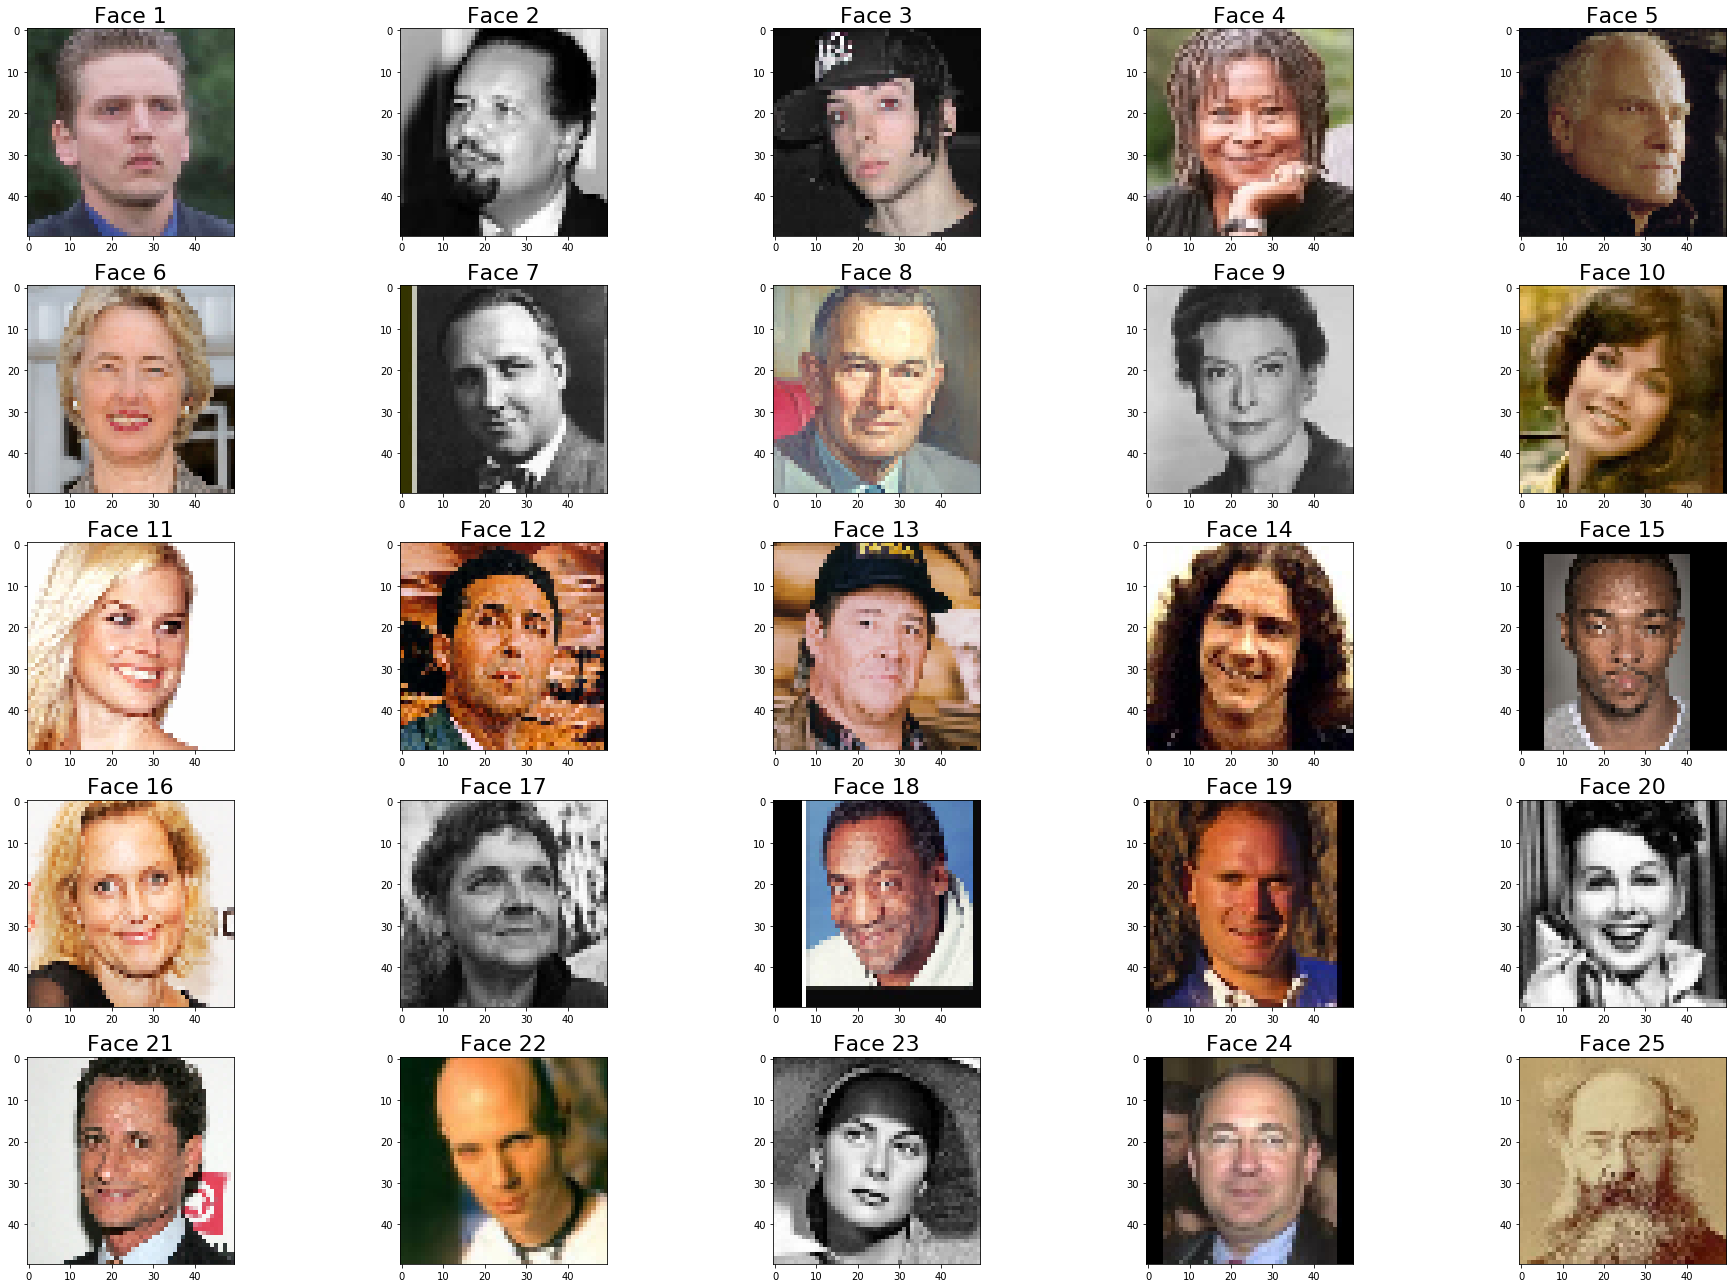

In [4]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(27, 18))

for i, ax in enumerate(axs.flat):
    
    ax.imshow(pics[i])    
    ax.set_title('Face %s' % (i+1), fontsize=22)

plt.tight_layout()
plt.show()

# 2. Коллаж после нормализации

Из каждого вектор-лица вычитаем средний вектор по всем лицам. Смотрим что будет на примере тех же первых 25 лицах.

In [5]:
normalized_pics = decomp.get_centered_pics()

In [6]:
normalized_pics[0]

array([[ -52.374,  -31.772,  -45.848],
       [  72.626,   76.228,   78.152],
       [ -95.374,  -91.772,  -89.848],
       ...,
       [ 143.626,  147.228,  149.152],
       [  96.626,  -36.772,  -70.848],
       [-103.374,  -99.772,  -97.848]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

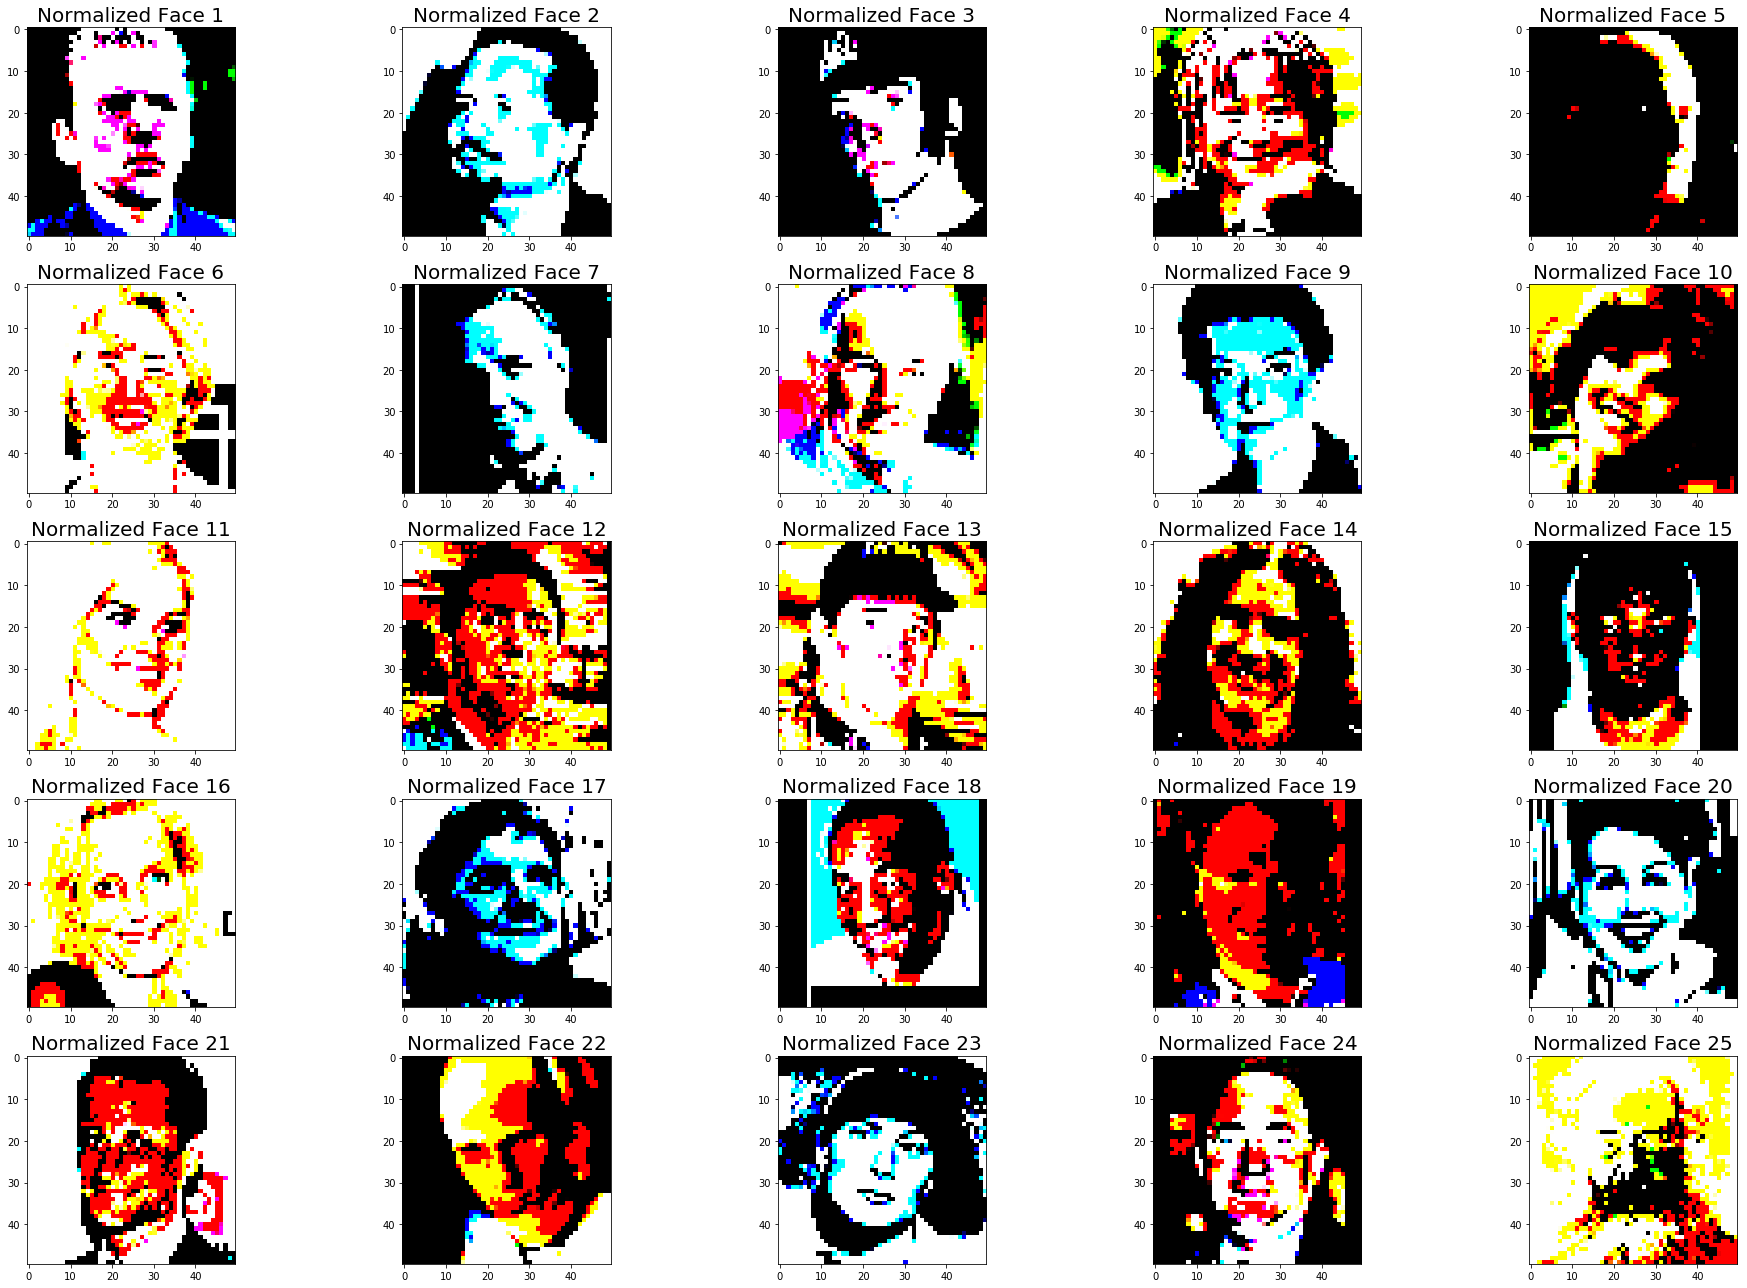

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(27, 18))

for i, ax in enumerate(axs.flat):

    ax.imshow(normalized_pics[:, i, :].reshape((decomp.pic_size, decomp.pic_size, 3)))    
    ax.set_title('Normalized Face %s' % (i+1), fontsize=20)

plt.tight_layout()
plt.show()

# 3. Усредненное лицо

При нормализации выше мы вычитали из каждого вектор-лица усредненное вектор-лицо. Посмотрим как это усредненное вектор-лицо выглядит.

In [13]:
mean_face = decomp.get_mean_pic()

In [7]:
mean_face

array([[103.374,  99.772,  97.848],
       [108.636, 105.034, 102.887],
       [113.649, 110.613, 107.752],
       ...,
       [ 79.999,  75.627,  74.331],
       [ 79.27 ,  74.912,  73.428],
       [ 77.328,  73.055,  71.6  ]])

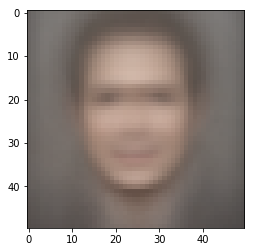

In [8]:
# тут astype(np.uint8) округляет интенсивности пикселей в целые числа

plt.imshow(mean_face.reshape((decomp.pic_size, decomp.pic_size, 3)).astype(np.uint8))

# 4. Базовые лица: вектора-столбцы матрицы U при SVD разложении

Нас интересуют только первые k столбцов U соответствующие самым большим сингулярным значениям.

In [15]:
r, g, b = decomp.compute_svd()

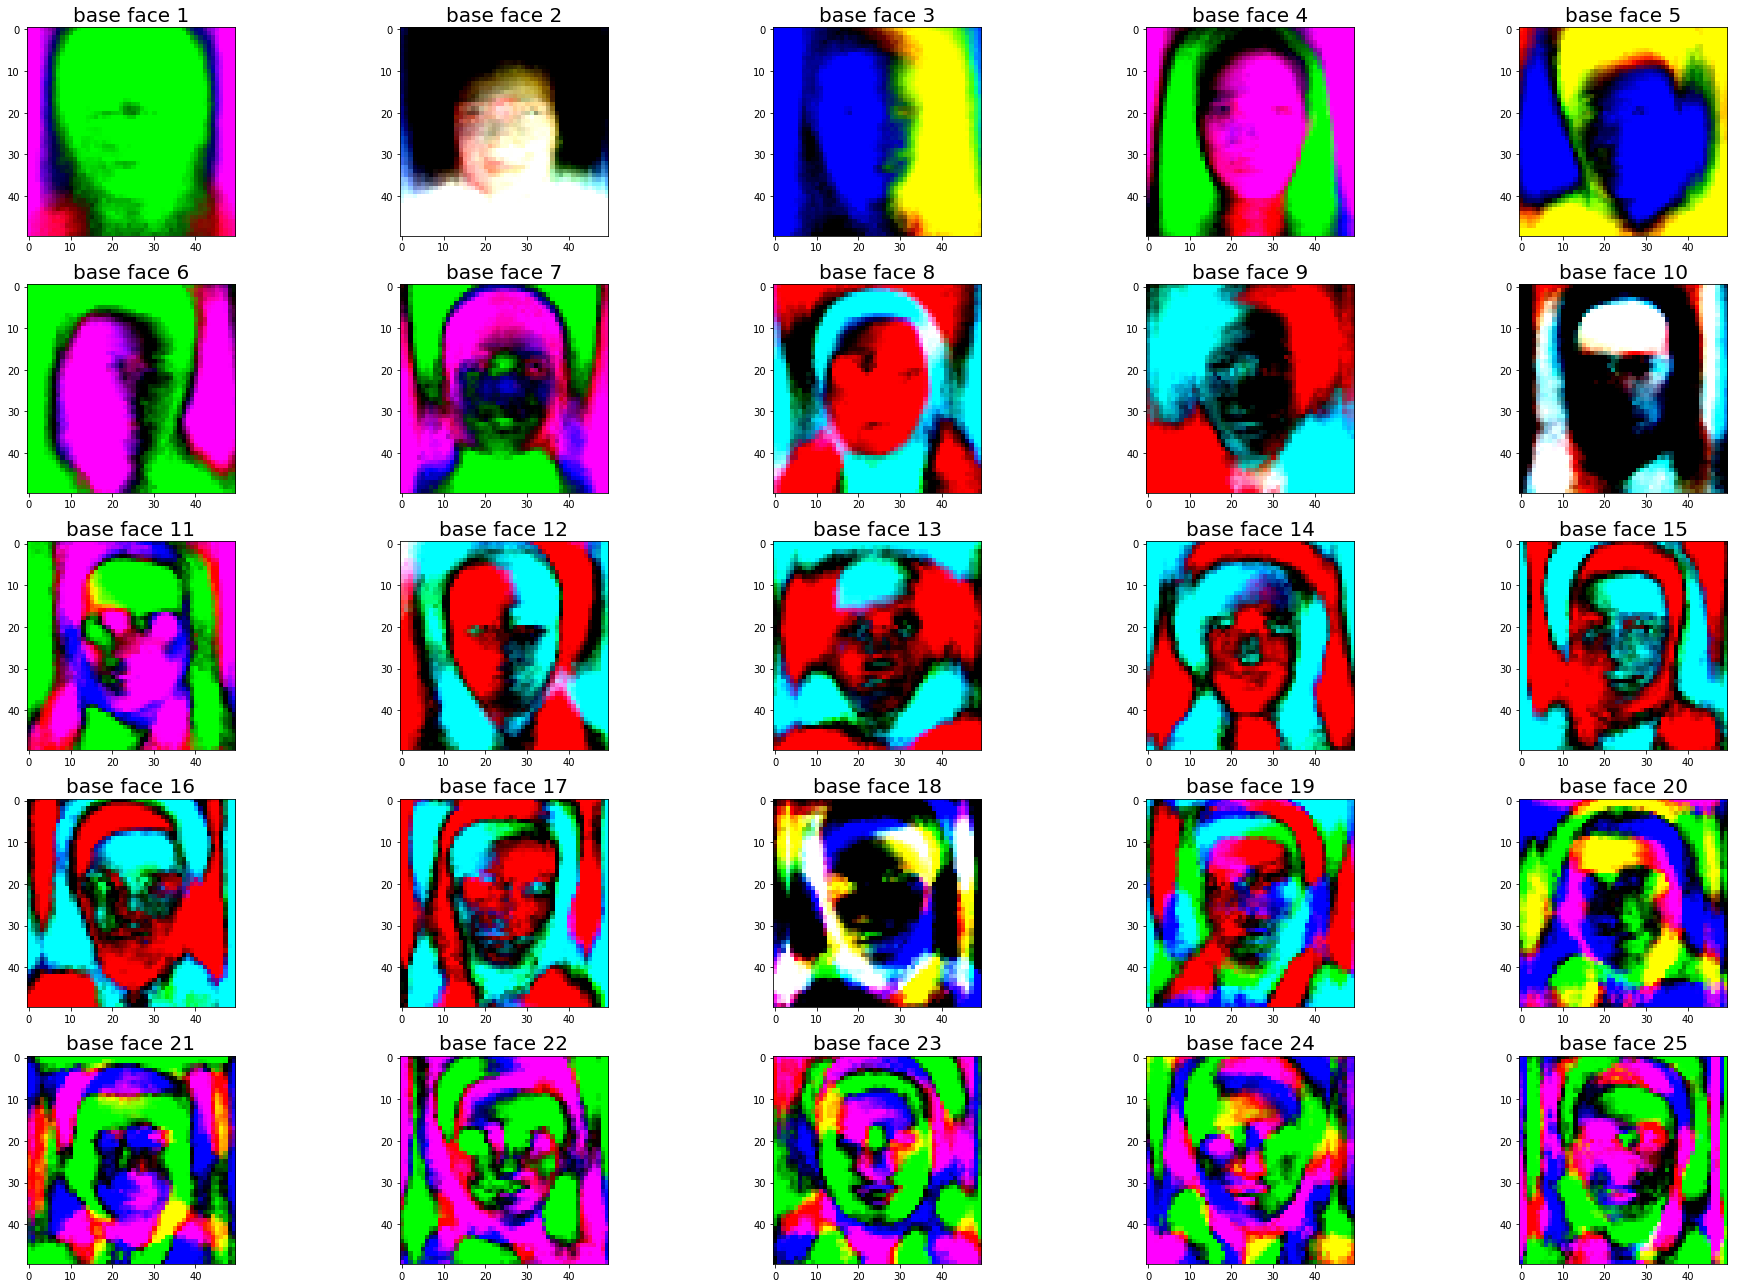

In [12]:
# Проблема при отображении: как линейно преобразовать интенсивность пикселей чтобы базовые лица были смотрибельны.
# Большая свобода выбора

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(27, 18))

for i, ax in enumerate(axs.flat, 1):
    
    base_face = (np.stack((r[0][:, i], g[0][:, i], b[0][:, i]), axis=1))*10
    
    base_face_show = base_face.reshape((decomp.pic_size, decomp.pic_size, 3)) * 7
    base_face_show[base_face_show < 0] = 0
    base_face_show[base_face_show > 1] = 1
    ax.imshow(base_face_show) 
    
    
    ax.set_title('base face %s' % i, fontsize=20)

plt.tight_layout()
plt.show()

# 5. Скалярные проекции вектор-лиц на базовые лица

In [120]:
projections = decomp.get_subspace_pics()

100%|██████████| 1000/1000 [01:25<00:00, 11.63it/s]


# 6. Распознавание

# eps_1

In [215]:
eps_1 = decomp.compute_eps_1('noface/')

100% (1000 of 1000) |####################| Elapsed Time: 0:01:34 Time:  0:01:34
100% (110 of 110) |######################| Elapsed Time: 0:00:13 Time:  0:00:13


In [216]:
eps_1

1220.018558122775

# eps_ 0

In [ ]:
eps_0 = decomp.compute_eps_0()
eps_0

# face recognition metrics

In [496]:
y_true = np.arange(1000)
y_true = [str(elem) for elem in y_true]

In [497]:
from progressbar import progressbar as pb
pred_paths = []
        
for path, subdirs, files in os.walk('CyberextruderUltimate/'):
    for name in files:
        if name.endswith('000002.jpg'):
            pred_paths.append(os.path.join(path, name))

pred_paths = sorted(pred_paths)

In [498]:
y_pred = []

for path in pb(pred_paths):
    pic = Image.open(path)
    pic = pic.resize((decomp.pic_size, decomp.pic_size))
    pic = np.array(pic)
    y_pred.append(decomp.recognize(pic, False, 'noface/'))

100% (1000 of 1000) |####################| Elapsed Time: 0:04:26 Time:  0:04:26


In [420]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy:', accuracy_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred, average='micro'))
print('Recall:', recall_score(y_true, y_pred, average='micro'))
print('F1 Score:', f1_score(y_true, y_pred, average='micro'))
print()
print('# Non-faces:', y_pred.count('Not a face!'))
print('# Unknown faces:', y_pred.count('Unknown face!'))


Accuracy: 0.27
Precision: 0.27
Recall: 0.27
F1 Score: 0.27

# Non-faces: 12
# Unknown faces: 1


CyberextruderUltimate/000427/000002.jpg


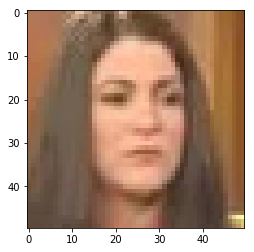

In [576]:
random_file_path = 'CyberextruderUltimate/000427/000002.jpg'

pic = Image.open(random_file_path)
pic = pic.resize((decomp.pic_size, decomp.pic_size))
pic = np.array(pic)
print(random_file_path)
plt.imshow(pic)


CyberextruderUltimate/000427/000001.jpg


'426'

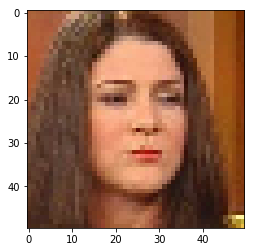

In [577]:
decomp.recognize(pic, True, 'nofaces/')

# face determination metrics

In [470]:
pred_paths_true = []
        
for path, subdirs, files in os.walk('CyberextruderUltimate/'):
    for name in files:
        if name.endswith('000003.jpg'):
            pred_paths_true.append(os.path.join(path, name))

pred_paths_true = sorted(pred_paths_true)

In [472]:
pred_paths_false_1000 = []
        
for path, subdirs, files in os.walk('val2017/'):
    for name in files:
        if name.endswith('jpg'):
            pred_paths_false.append(os.path.join(path, name))

random.Random(12).shuffle(pred_paths_false)
i = 0 

while len(pred_paths_false_1000) != 1000:
    pic = Image.open(pred_paths_false[i])
    pic = pic.resize((decomp.pic_size, decomp.pic_size))
    pic = np.array(pic)
    if pic.shape == (50,50,3):
        pred_paths_false_1000.append(pred_paths_false[i])
    i+=1

In [475]:
pred_paths = pred_paths_true + pred_paths_false_1000

In [478]:
y_pred = []

for path in pb(pred_paths):
    pic = Image.open(path)
    pic = pic.resize((decomp.pic_size, decomp.pic_size))
    pic = np.array(pic)
    y_pred.append(decomp.recognize(pic, False, 'noface/'))

100% (2000 of 2000) |####################| Elapsed Time: 0:08:21 Time:  0:08:21


In [490]:
y_pred_fin = [1 if elem != 'Not a face!' else 0 for elem in y_pred]
y_true_fin = [1] * 1000 + [0] * 1000

In [495]:
print('Accuracy:', accuracy_score(y_true_fin, y_pred_fin))
print('Precision:', precision_score(y_true_fin, y_pred_fin, average='micro'))
print('Recall:', recall_score(y_true_fin, y_pred_fin, average='micro'))
print('F1 Score:', f1_score(y_true_fin, y_pred_fin, average='micro'))


Accuracy: 0.7245
Precision: 0.8046831634391061
Recall: 0.7245
F1 Score: 0.7050977151495479


/Users/user/Python/HW/Linal/val2017/000000028285.jpg


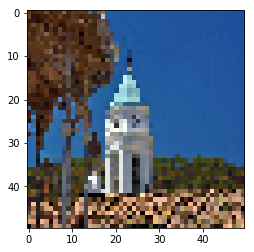

In [591]:
random_file_path = '/Users/user/Python/HW/Linal/val2017/000000028285.jpg'

pic = Image.open(random_file_path)
pic = pic.resize((decomp.pic_size, decomp.pic_size))
pic = np.array(pic)
print(random_file_path)
plt.imshow(pic)

In [592]:
decomp.recognize(pic, True, 'nofaces/')

'Not a face!'

/Users/user/Python/HW/Linal/val2017/000000005477.jpg


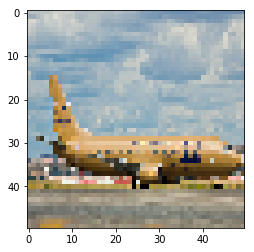

In [593]:
random_file_path = '/Users/user/Python/HW/Linal/val2017/000000005477.jpg'

pic = Image.open(random_file_path)
pic = pic.resize((decomp.pic_size, decomp.pic_size))
pic = np.array(pic)
print(random_file_path)
plt.imshow(pic)

CyberextruderUltimate/000049/000001.jpg


'48'

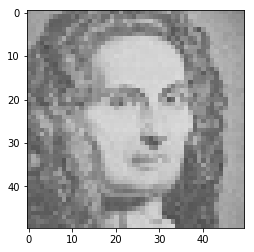

In [594]:
decomp.recognize(pic, True, 'nofaces/')